In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output1

In [49]:
class mmk_finite_two_populations():
    """
    A class representing an M/M/K queue system with finite queue size for two populations (ING, PREPA).
    
    Attributes:
        lamda_ing (float): Arrival rate of ING population
        lamda_prepa (float): Arrival rate of PREPA population
        mu_ing (float): Service rate for ING population
        mu_prepa (float): Service rate for PREPA population
        k (int): Number of servers
        Ks (int): Maximum queue size
        gen (np.random): Random number generator
        test_z (int): Number of pushes to simulate
        refused_pushes_ing (int): Refused pushes for ING population
        refused_pushes_prepa (int): Refused pushes for PREPA population
        tops (pd.DataFrame): Timing data for each push
    """
    
    def __init__(self, lamda_ing, lamda_prepa, mu_ing, mu_prepa, k, Ks, gen, test_z=100):
        """
        Initialize M/M/K queue system with finite queue for two populations.
        
        Args:
            lamda_ing: Arrival rate for ING population
            lamda_prepa: Arrival rate for PREPA population
            mu_ing: Service rate for ING population
            mu_prepa: Service rate for PREPA population
            k: Number of servers
            Ks: Maximum queue size
            gen: Random number generator
            test_z: Number of pushes to simulate
        """
        # Queue parameters
        self.lamda_ing = lamda_ing
        self.lamda_prepa = lamda_prepa
        self.mu_ing = mu_ing
        self.mu_prepa = mu_prepa
        self.k = k
        self.Ks = Ks
        self.gen = gen
        self.t_size = test_z
        self.refused_pushes_ing = 0
        self.refused_pushes_prepa = 0
        
        # Initialize timing DataFrame
        self.tops = pd.DataFrame(
            index=range(test_z),
            columns=['t_arrival', 't_service_start', 't_departure', 'population'],
            data=np.zeros((test_z, 4))
        )
        
    def run(self):
        """
        Simulate the M/M/K queue system with finite queue size for two populations.
        """
        print("Running the M/M/K queue simulation for two populations")
        
        # Add timing columns
        self.tops["t_waiting"] = np.zeros(self.t_size)
        self.tops["t_service"] = np.zeros(self.t_size)
        self.tops["t_sojourn"] = np.zeros(self.t_size)
        
        # Track server availability times
        server_available = np.zeros(self.k)
        
        # Generate arrival times for both populations
        arrivals_ing = np.cumsum(self.gen.exponential(1 / self.lamda_ing, self.t_size // 2))
        arrivals_prepa = np.cumsum(self.gen.exponential(1 / self.lamda_prepa, self.t_size // 2))
        
        # Merge and sort arrival times, adding population labels
        arrivals = np.concatenate((arrivals_ing, arrivals_prepa))
        populations = ['ING'] * len(arrivals_ing) + ['PREPA'] * len(arrivals_prepa)
        combined = sorted(zip(arrivals, populations))
        
        # Process pushes
        for i, (arrival_time, population) in enumerate(combined):
            self.tops.loc[i, "t_arrival"] = arrival_time
            self.tops.loc[i, "population"] = population
            
            # Count pushes currently in queue
            current_time = arrival_time
            in_queue = ((self.tops["t_arrival"] <= current_time) & 
                       (self.tops["t_service_start"] > current_time)).sum()
            
            # Check if queue size limit is exceeded
            if in_queue >= self.Ks:
                if population == 'ING':
                    self.refused_pushes_ing += 1
                else:
                    self.refused_pushes_prepa += 1
                continue
                
            # Find first available server
            server_idx = np.argmin(server_available)
            
            # Calculate service start time
            self.tops.loc[i, "t_service_start"] = max(server_available[server_idx], arrival_time)
            
            # Calculate waiting and service times
            self.tops.loc[i, "t_waiting"] = self.tops.loc[i, "t_service_start"] - arrival_time
            if population == 'ING':
                self.tops.loc[i, "t_service"] = self.gen.exponential(1 / self.mu_ing)
            else:
                self.tops.loc[i, "t_service"] = self.gen.exponential(1 / self.mu_prepa)
            
            # Calculate departure time
            self.tops.loc[i, "t_departure"] = self.tops.loc[i, "t_service_start"] + self.tops.loc[i, "t_service"]
            self.tops.loc[i, "t_sojourn"] = self.tops.loc[i, "t_waiting"] + self.tops.loc[i, "t_service"]
            
            # Update server availability
            server_available[server_idx] = self.tops.loc[i, "t_departure"]

    def counts(self, t_intervals, population= "BOTH"):
        """
        Compute number of pushes in system at regular time intervals.
        
        Args:
            t_intervals: Time interval size for measurements
            
        Returns:
            DataFrame with counts of pushes in system, queue and service
        """
        t_max = self.tops["t_departure"].max()
        t_points = np.arange(0, t_max, t_intervals)
        
        counts = pd.DataFrame(
            index=t_points,
            columns=['ag_in_sys', 'ag_in_queue', 'ag_in_service'],
            data=np.zeros((len(t_points), 3))
        )

        if (population == "BOTH"):
            for t in t_points:
                in_sys = ((self.tops["t_arrival"] <= t) & (self.tops["t_departure"] > t)).sum()
                in_queue = ((self.tops["t_arrival"] <= t) & (self.tops["t_service_start"] > t)).sum()
                in_service = ((self.tops["t_service_start"] <= t) & (self.tops["t_departure"] > t)).sum()
                
                counts.loc[t] = [in_sys, in_queue, in_service]
        
        else:
            filtered_tops = self.tops[self.tops["population"] == population]

            for t in t_points:
                in_sys = ((filtered_tops["t_arrival"] <= t) & (filtered_tops["t_departure"] > t)).sum()
                in_queue = ((filtered_tops["t_arrival"] <= t) & (filtered_tops["t_service_start"] > t)).sum()
                in_service = ((filtered_tops["t_service_start"] <= t) & (filtered_tops["t_departure"] > t)).sum()
                
                counts.loc[t] = [in_sys, in_queue, in_service]     
        return counts
    
    def stats(self):
        """
        Compute summary statistics for the two populations.
        
        Returns:
            DataFrames with statistics for each population.
        """
        stats_ing = self.tops[self.tops["population"] == 'ING'][["t_waiting", "t_service", "t_sojourn"]].mean()
        stats_prepa = self.tops[self.tops["population"] == 'PREPA'][["t_waiting", "t_service", "t_sojourn"]].mean()
        
        stats = pd.DataFrame({
            'Population': ['ING', 'PREPA'],
            'Mean Waiting Time': [stats_ing["t_waiting"], stats_prepa["t_waiting"]],
            'Mean Service Time': [stats_ing["t_service"], stats_prepa["t_service"]],
            'Mean Sojourn Time': [stats_ing["t_sojourn"], stats_prepa["t_sojourn"]],
            'Refused Pushes': [self.refused_pushes_ing, self.refused_pushes_prepa]
        })
        
        return stats

In [50]:
class mm1_finite():
    """
    A class representing an M/M/1 queue system with finite queue capacity for processing student results
    
    Attributes:
        lamda (float): Arrival rate of results
        mu (float): Service rate of the server
        gen (np.random): Random number generator
        test_z (int): Number of results to simulate
        Kf (int): Maximum queue capacity
        tops (pd.DataFrame): DataFrame containing timing data for each result
        refused_pushes (int): Counter for refused pushes due to queue capacity
    """
    
    def __init__(self, lamda, mu, gen, Kf, test_z=100, previous_tops=None):
        """
        Initialize M/M/1 queue system with finite capacity.
        
        Args:
            lamda: Arrival rate of results
            mu: Service rate of server
            gen: Random number generator
            Kf: Maximum queue capacity
            test_z: Number of results to simulate
        """
        # Queue parameters
        self.lamda = lamda
        self.mu = mu
        self.k = 1
        self.Kf = Kf
        self.gen = gen
        self.t_size = test_z
        self.refused_pushes = 0
        
        # Initialize timing DataFrame
        if previous_tops is None:
            self.tops = pd.DataFrame(
                index=range(test_z),
                columns=['t_arrival', 't_service_start', 't_departure'],
                data=np.zeros((test_z, 3))
            )
        else:
            self.tops = previous_tops
        
    def run(self):
        """
        Simulate the M/M/1 queue system with finite capacity.
        
        For each result:
        1. Generate arrival time based on exponential interarrival times
        2. Check if queue capacity is exceeded
        3. Find first available server if accepted
        4. Generate service time from exponential distribution
        5. Calculate departure time
        
        Also computes waiting time, service time and total sojourn time for each result.
        """
        print("Running the M/M/1 queue simulation with finite capacity")
        
        # Add timing columns
        self.tops["t_waiting"] = np.zeros(self.t_size)
        self.tops["t_service"] = np.zeros(self.t_size)
        self.tops["t_sojourn"] = np.zeros(self.t_size)
        
        # Track server availability times
        server_available = np.zeros(self.k)
        
        # Process first result
        self.tops.loc[0, "t_service"] = self.gen.exponential(1/self.mu)
        self.tops.loc[0, "t_service_start"] = self.tops.loc[0, "t_arrival"]
        self.tops.loc[0, "t_waiting"] = 0.0
        self.tops.loc[0, "t_departure"] = self.tops.loc[0, "t_service_start"] + self.tops.loc[0, "t_service"]
        self.tops.loc[0, "t_sojourn"] = self.tops.loc[0, "t_waiting"] + self.tops.loc[0, "t_service"]
        server_available[0] = self.tops.loc[0, "t_departure"]
        
        # Process remaining results
        for i in range(1, self.t_size):
            # Check queue capacity
            in_queue = ((self.tops["t_arrival"] <= self.tops.loc[i, "t_arrival"]) & 
                       (self.tops["t_service_start"] > self.tops.loc[i, "t_arrival"])).sum()
            
            if in_queue >= self.Kf:
                self.refused_pushes += 1
                continue
                
            # Find available server
            server_idx = np.argmin(server_available)
            
            # Calculate service start time
            self.tops.loc[i, "t_service_start"] = max(server_available[server_idx], self.tops.loc[i, "t_arrival"])
            
            # Calculate waiting and service times
            self.tops.loc[i, "t_waiting"] = self.tops.loc[i, "t_service_start"] - self.tops.loc[i, "t_arrival"]
            self.tops.loc[i, "t_service"] = self.gen.exponential(1/self.mu)
            
            # Calculate departure time
            self.tops.loc[i, "t_departure"] = self.tops.loc[i, "t_service_start"] + self.tops.loc[i, "t_service"]
            self.tops.loc[i, "t_sojourn"] = self.tops.loc[i, "t_waiting"] + self.tops.loc[i, "t_service"]
            
            # Update server availability
            server_available[server_idx] = self.tops.loc[i, "t_departure"]
    
    def counts(self, t_intervals):
        """
        Compute number of results in system at regular time intervals.
        
        Args:
            t_intervals: Time interval size for measurements
            
        Returns:
            DataFrame with counts of results in system, queue and service
        """
        t_max = self.tops["t_departure"].max()
        t_points = np.arange(0, t_max, t_intervals)
        
        counts = pd.DataFrame(
            index=t_points,
            columns=['ag_in_sys', 'ag_in_queue', 'ag_in_service'],
            data=np.zeros((len(t_points), 3))
        )
        
        for t in t_points:
            in_sys = ((self.tops["t_arrival"] <= t) & (self.tops["t_departure"] > t)).sum()
            in_queue = ((self.tops["t_arrival"] <= t) & (self.tops["t_service_start"] > t)).sum()
            in_service = ((self.tops["t_service_start"] <= t) & (self.tops["t_departure"] > t)).sum()
            
            counts.loc[t] = [in_sys, in_queue, in_service]
            
        return counts

    def stats(self):
        """
        Compute summary statistics for the queue simulation.
        
        Returns:
            DataFrame with mean sojourn time, waiting time, service time, refused pushes
            and arrival/departure times
        """
        # Calculate mean statistics
        stats = pd.DataFrame(
            index=['mean_sojourn_time', 'mean_waiting_time', 'mean_service_time', 'refused_pushes'],
            columns=['value'],
            data=[
                self.tops["t_sojourn"].mean(),
                self.tops["t_waiting"].mean(), 
                self.tops["t_service"].mean(),
                self.refused_pushes
            ]
        )
        
        # Add arrival and departure times
        arrivals_departures = pd.DataFrame({
            'Arrival Time': self.tops["t_arrival"],
            'Departure Time': self.tops["t_departure"]
        })
        
        return stats, arrivals_departures

Running the M/M/K queue simulation for two populations


/tmp/ipykernel_4744/590311171.py:78: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'PREPA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.tops.loc[i, "population"] = population


Running the M/M/1 queue simulation with finite capacity

Statistiques de la file M/M/K:
  Population  Mean Waiting Time  Mean Service Time  Mean Sojourn Time  \
0        ING           0.028309           0.408880           0.437189   
1      PREPA           0.017761           0.836956           0.854717   

   Refused Pushes  
0               4  
1               1  

Statistiques de la file M/M/1:
(                         value
mean_sojourn_time     3.044094
mean_waiting_time     2.608716
mean_service_time     0.435378
refused_pushes     2477.000000,       Arrival Time  Departure Time
0         0.529900        0.926899
1         1.359172        1.803483
2         3.486026        3.935964
3         3.006515        6.005168
4         4.278414        6.023460
...            ...             ...
4995   2385.216431     2391.115652
4996   2385.398334     2392.456447
4997   2387.502109     2393.607507
4998   2387.687519     2393.795772
4999   2388.375185     2394.156688

[5000 rows x 2 columns

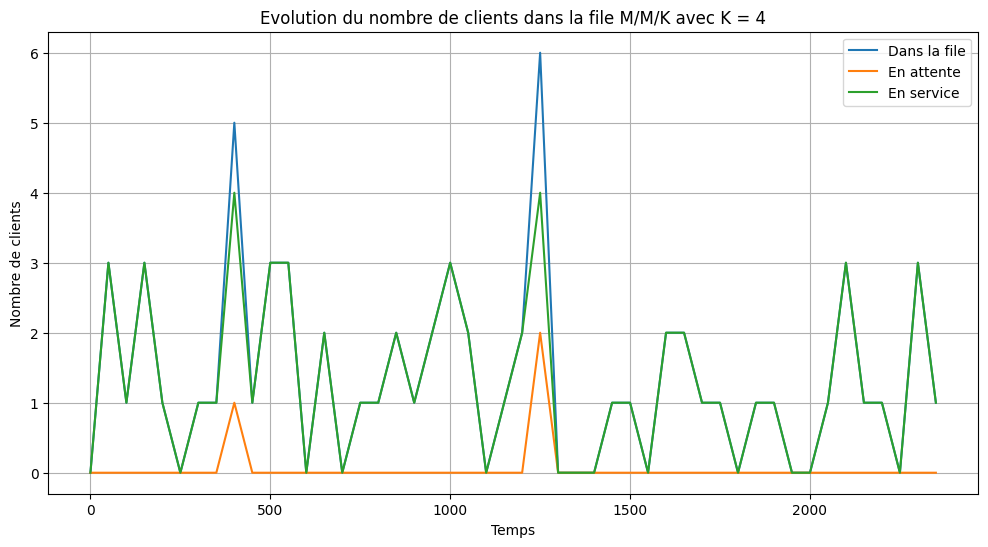

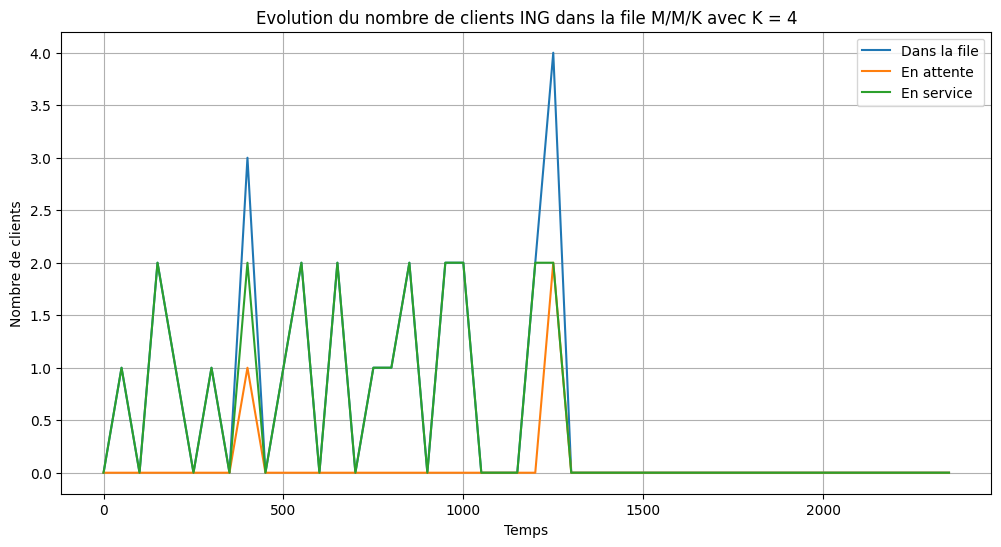

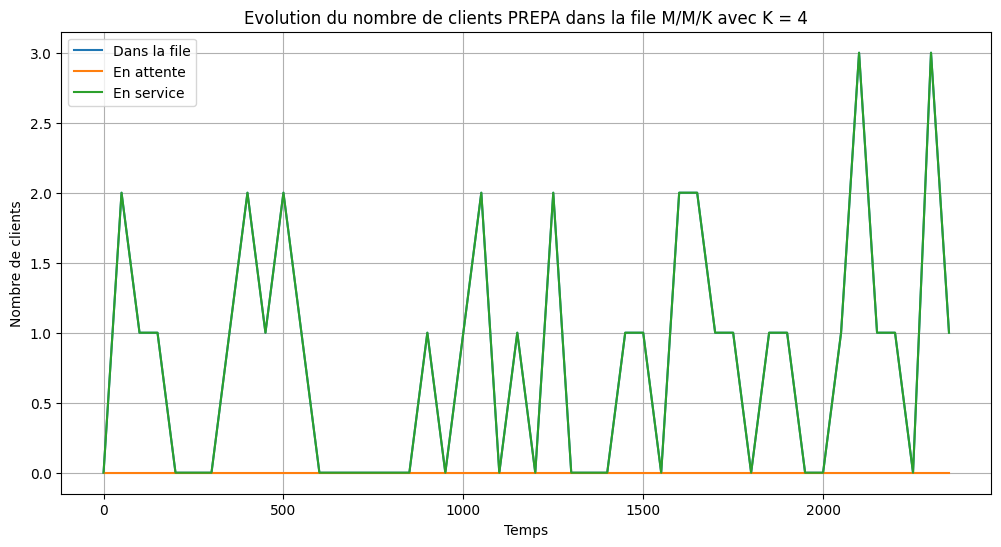

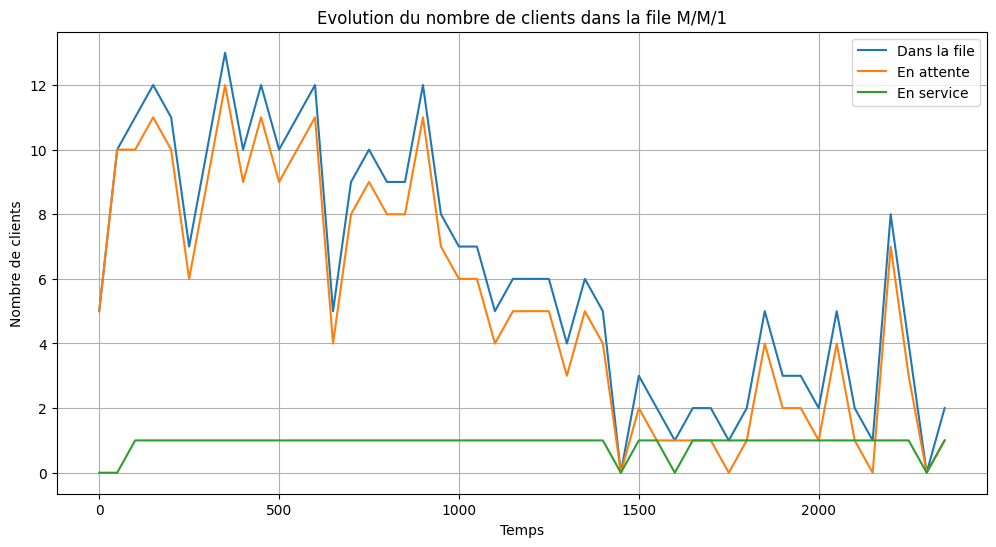

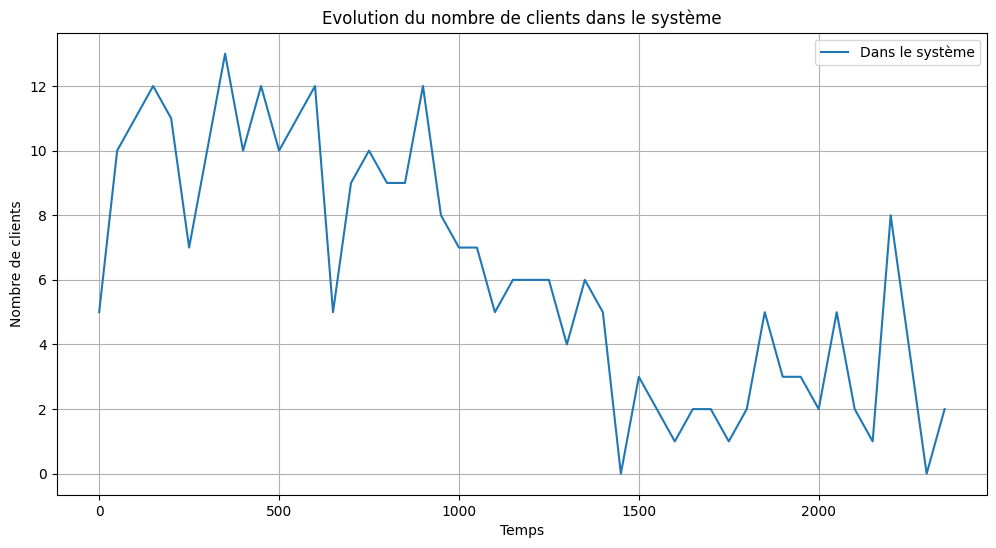

In [51]:
# Paramètres de la file M/M/K
lambda_arr_ing = 2.0  # Taux d'arrivée des pushs population ing
lambda_arr_prepa = 1.0 # Taux d'arrivée des pushs population prepa
mu_1_ing = 2.4 # Taux de service des serveurs population ing
mu_1_prepa = 1.2 # Taux de service des serveurs population prepa
K = 4            # Nombre de serveurs
gen = np.random.default_rng(seed=42)
z = 5000
Ks = 5 # Maximum queue capacity for M/M/K

# Paramètres de la file M/M/1
lambda_arr_2 = 1.0  # Taux d'arrivée des pushs
mu_2 = 1.2       # Taux de service du serveur
Kf = 5 # Maximum queue capacity for M/M/1

# Créer une instance de la file M/M/K
mmk_queue = mmk_finite_two_populations(lamda_ing=lambda_arr_ing, lamda_prepa=lambda_arr_prepa,mu_ing=mu_1_ing, mu_prepa=mu_1_prepa, k=K, Ks=Ks, gen=gen, test_z=z)

# Simuler la file d'attente
mmk_queue.run()

prev_tops = pd.DataFrame(
                index=range(z),
                columns=['t_arrival', 't_service_start', 't_departure'],
                data=np.zeros((z, 3))
            )
prev_tops["t_arrival"] = mmk_queue.tops["t_departure"]

# Créer une instance de la file M/M/1
mm1_queue = mm1_finite(lamda=lambda_arr_2, mu=mu_2, gen=gen, Kf=Kf, test_z=z, previous_tops=prev_tops)

# Simuler la file d'attente
mm1_queue.run()

# Afficher les statistiques
print("\nStatistiques de la file M/M/K:")
print(mmk_queue.stats())

print("\nStatistiques de la file M/M/1:")
print(mm1_queue.stats())

# Calculer les comptages à intervalles réguliers pour la file M/M/K
counts_df_k = mmk_queue.counts(t_intervals=50,)

# Tracer l'évolution du nombre de clients dans la file M/M/K
plt.figure(figsize=(12, 6))
plt.plot(counts_df_k.index, counts_df_k['ag_in_sys'], label='Dans la file')
plt.plot(counts_df_k.index, counts_df_k['ag_in_queue'], label='En attente')
plt.plot(counts_df_k.index, counts_df_k['ag_in_service'], label='En service')
plt.xlabel('Temps')
plt.ylabel('Nombre de clients')
plt.title('Evolution du nombre de clients dans la file M/M/K avec K = ' + str(K))
plt.legend()
plt.grid(True)
plt.show()

# Tracer l'évolution du nombre de clients ing dans la file M/M/K
counts_df_k = mmk_queue.counts(t_intervals=50, population="ING")

plt.figure(figsize=(12, 6))
plt.plot(counts_df_k.index, counts_df_k['ag_in_sys'], label='Dans la file')
plt.plot(counts_df_k.index, counts_df_k['ag_in_queue'], label='En attente')
plt.plot(counts_df_k.index, counts_df_k['ag_in_service'], label='En service')
plt.xlabel('Temps')
plt.ylabel('Nombre de clients')
plt.title('Evolution du nombre de clients ING dans la file M/M/K avec K = ' + str(K))
plt.legend()
plt.grid(True)
plt.show()

# Tracer l'évolution du nombre de clients prepa dans la file M/M/K
counts_df_k = mmk_queue.counts(t_intervals=50, population="PREPA")

plt.figure(figsize=(12, 6))
plt.plot(counts_df_k.index, counts_df_k['ag_in_sys'], label='Dans la file')
plt.plot(counts_df_k.index, counts_df_k['ag_in_queue'], label='En attente')
plt.plot(counts_df_k.index, counts_df_k['ag_in_service'], label='En service')
plt.xlabel('Temps')
plt.ylabel('Nombre de clients')
plt.title('Evolution du nombre de clients PREPA dans la file M/M/K avec K = ' + str(K))
plt.legend()
plt.grid(True)
plt.show()

# Calculer les comptages à intervalles réguliers pour la file M/M/1
counts_df_1 = mm1_queue.counts(t_intervals=50)

# Tracer l'évolution du nombre de clients dans la file M/M/1
plt.figure(figsize=(12, 6))
plt.plot(counts_df_1.index, counts_df_1['ag_in_sys'], label='Dans la file')
plt.plot(counts_df_1.index, counts_df_1['ag_in_queue'], label='En attente')
plt.plot(counts_df_1.index, counts_df_1['ag_in_service'], label='En service')
plt.xlabel('Temps')
plt.ylabel('Nombre de clients')
plt.title('Evolution du nombre de clients dans la file M/M/1')
plt.legend()
plt.grid(True)
plt.show()

# Tracer l'évolution du nombre de clients dans le système
plt.figure(figsize=(12, 6))
plt.plot(counts_df_1.index, counts_df_1['ag_in_sys'], label='Dans le système')
plt.xlabel('Temps')
plt.ylabel('Nombre de clients')
plt.title('Evolution du nombre de clients dans le système')
plt.legend()
plt.grid(True)
plt.show()


Top 5 most efficient configurations:
     k  Ks  mu_ing  mu_prepa  ing_sojourn  prepa_sojourn  ing_refused  \
224  3   6     3.6       1.8     0.303248       0.547395            0   
244  3   7     3.2       1.8     0.323743       0.557603            0   
249  3   7     3.6       1.8     0.308349       0.582129            0   
219  3   6     3.2       1.8     0.333423       0.566199            0   
243  3   7     3.2       1.6     0.355734       0.638570            0   

     prepa_refused  utilization  efficiency_score  
224              0     0.370370         -3.850643  
244              0     0.400000         -3.881345  
249              0     0.370370         -3.890478  
219              0     0.400000         -3.899621  
243              0     0.416667         -3.994304  


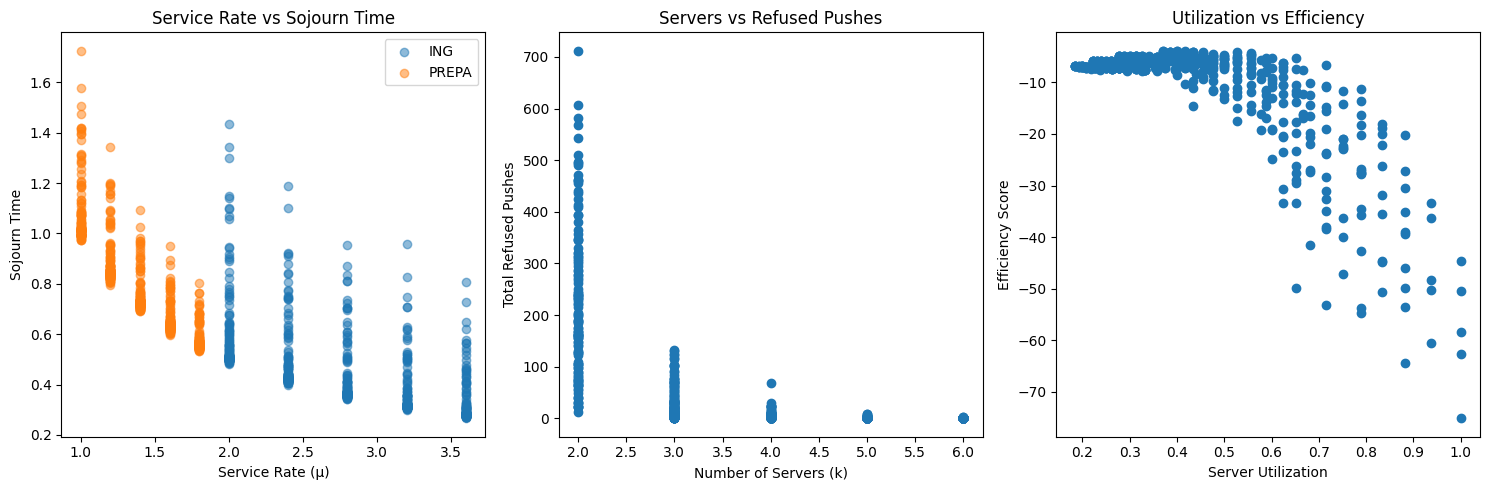

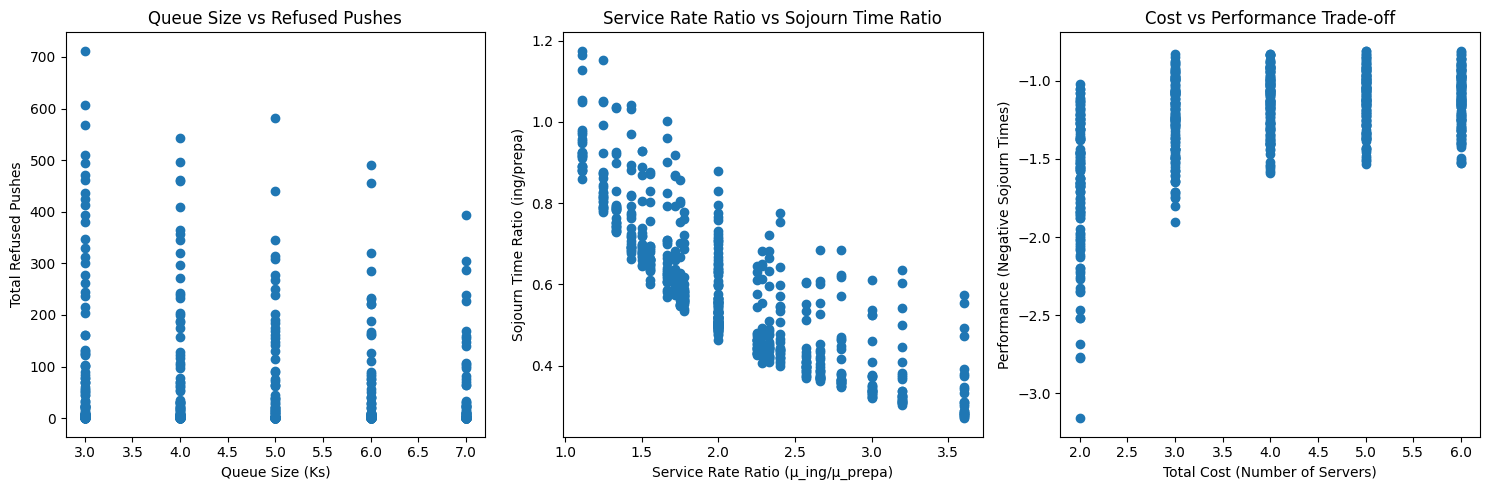

In [52]:
def optimize_parameters(base_lambda_ing, base_lambda_prepa, 
                       mu_ing_range, mu_prepa_range, 
                       k_range, ks_range, 
                       test_z=5000):
    """
    Find optimal parameters by testing different combinations.
    
    Args:
        base_lambda_ing/prepa: Fixed arrival rates (assumed given by real system)
        mu_ing_range/mu_prepa_range: Range of service rates to test
        k_range: Range of server numbers to test
        ks_range: Range of queue sizes to test
        test_z: Number of simulations
    
    Returns:
        DataFrame with results and best configurations
    """
    results = []
    gen = np.random.default_rng(seed=42)
    
    for k in k_range:
        for ks in ks_range:
            for mu_ing in mu_ing_range:
                for mu_prepa in mu_prepa_range:
                    # Run simulation
                    mmk_queue = mmk_finite_two_populations(
                        lamda_ing=base_lambda_ing,
                        lamda_prepa=base_lambda_prepa,
                        mu_ing=mu_ing,
                        mu_prepa=mu_prepa,
                        k=k,
                        Ks=ks,
                        gen=gen,
                        test_z=test_z
                    )
                    mmk_queue.run()
                    stats = mmk_queue.stats()

                    clear_output(wait=True)
                    
                    # Calculate efficiency metrics
                    ing_stats = stats[stats['Population'] == 'ING'].iloc[0]
                    prepa_stats = stats[stats['Population'] == 'PREPA'].iloc[0]
                    
                    # Calculate server utilization
                    total_arrival_rate = base_lambda_ing + base_lambda_prepa
                    avg_service_rate = (mu_ing + mu_prepa) / 2
                    utilization = total_arrival_rate / (k * avg_service_rate)
                    
                    results.append({
                        'k': k,
                        'Ks': ks,
                        'mu_ing': mu_ing,
                        'mu_prepa': mu_prepa,
                        'ing_sojourn': ing_stats['Mean Sojourn Time'],
                        'prepa_sojourn': prepa_stats['Mean Sojourn Time'],
                        'ing_refused': ing_stats['Refused Pushes'],
                        'prepa_refused': prepa_stats['Refused Pushes'],
                        'utilization': utilization,
                        'total_cost': k  # Cost model: assume cost proportional to number of servers
                    })
    
    results_df = pd.DataFrame(results)
    
    # Find Pareto-optimal configurations
    results_df['efficiency_score'] = (
        -results_df['ing_sojourn'] 
        - results_df['prepa_sojourn'] 
        - 0.1 * (results_df['ing_refused'] + results_df['prepa_refused'])
        - results_df['total_cost']
    )
    
    return results_df

# Example usage with wider parameter ranges
k_range = [2, 3, 4, 5, 6]
ks_range = [3, 4, 5, 6, 7]
mu_ing_range = [2.0, 2.4, 2.8, 3.2, 3.6]
mu_prepa_range = [1.0, 1.2, 1.4, 1.6, 1.8]

optimization_results = optimize_parameters(
    base_lambda_ing=2.0,
    base_lambda_prepa=1.0,
    mu_ing_range=mu_ing_range,
    mu_prepa_range=mu_prepa_range,
    k_range=k_range,
    ks_range=ks_range
)

# Show top 5 configurations
print("\nTop 5 most efficient configurations:")
print(optimization_results.nlargest(5, 'efficiency_score')[
    ['k', 'Ks', 'mu_ing', 'mu_prepa', 'ing_sojourn', 'prepa_sojourn', 
     'ing_refused', 'prepa_refused', 'utilization', 'efficiency_score']
])

# Visualize trade-offs
plt.figure(figsize=(15, 5))

# Plot 1: Service rates vs Sojourn times
plt.subplot(1, 3, 1)
plt.scatter(optimization_results['mu_ing'], 
           optimization_results['ing_sojourn'],
           alpha=0.5, label='ING')
plt.scatter(optimization_results['mu_prepa'], 
           optimization_results['prepa_sojourn'],
           alpha=0.5, label='PREPA')
plt.xlabel('Service Rate (μ)')
plt.ylabel('Sojourn Time')
plt.title('Service Rate vs Sojourn Time')
plt.legend()

# Plot 2: Number of servers vs Refused pushes
plt.subplot(1, 3, 2)
plt.scatter(optimization_results['k'], 
           optimization_results['ing_refused'] + optimization_results['prepa_refused'])
plt.xlabel('Number of Servers (k)')
plt.ylabel('Total Refused Pushes')
plt.title('Servers vs Refused Pushes')

# Plot 3: Utilization vs Efficiency
plt.subplot(1, 3, 3)
plt.scatter(optimization_results['utilization'], 
           optimization_results['efficiency_score'])
plt.xlabel('Server Utilization')
plt.ylabel('Efficiency Score')
plt.title('Utilization vs Efficiency')

plt.tight_layout()
plt.show()

# Additional analysis: Parameter sensitivity
plt.figure(figsize=(15, 5))

# Plot 1: Queue size vs Refused pushes
plt.subplot(1, 3, 1)
plt.scatter(optimization_results['Ks'], 
           optimization_results['ing_refused'] + optimization_results['prepa_refused'])
plt.xlabel('Queue Size (Ks)')
plt.ylabel('Total Refused Pushes')
plt.title('Queue Size vs Refused Pushes')

# Plot 2: Service rate ratio vs Sojourn time ratio
optimization_results['service_rate_ratio'] = optimization_results['mu_ing'] / optimization_results['mu_prepa']
optimization_results['sojourn_time_ratio'] = optimization_results['ing_sojourn'] / optimization_results['prepa_sojourn']

plt.subplot(1, 3, 2)
plt.scatter(optimization_results['service_rate_ratio'],
           optimization_results['sojourn_time_ratio'])
plt.xlabel('Service Rate Ratio (μ_ing/μ_prepa)')
plt.ylabel('Sojourn Time Ratio (ing/prepa)')
plt.title('Service Rate Ratio vs Sojourn Time Ratio')

# Plot 3: Cost vs Performance
optimization_results['performance'] = -(optimization_results['ing_sojourn'] + optimization_results['prepa_sojourn'])
plt.subplot(1, 3, 3)
plt.scatter(optimization_results['total_cost'],
           optimization_results['performance'])
plt.xlabel('Total Cost (Number of Servers)')
plt.ylabel('Performance (Negative Sojourn Times)')
plt.title('Cost vs Performance Trade-off')

plt.tight_layout()
plt.show()

Running the M/M/K queue simulation for two populations


/tmp/ipykernel_4744/590311171.py:78: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'PREPA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.tops.loc[i, "population"] = population


Running the M/M/K queue simulation for two populations


/tmp/ipykernel_4744/590311171.py:78: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ING' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.tops.loc[i, "population"] = population


Running the M/M/K queue simulation for two populations


/tmp/ipykernel_4744/590311171.py:78: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'PREPA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.tops.loc[i, "population"] = population


Running the M/M/K queue simulation for two populations


/tmp/ipykernel_4744/590311171.py:78: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'PREPA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.tops.loc[i, "population"] = population


Running the M/M/K queue simulation for two populations


/tmp/ipykernel_4744/590311171.py:78: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ING' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.tops.loc[i, "population"] = population


Running the M/M/K queue simulation for two populations


/tmp/ipykernel_4744/590311171.py:78: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ING' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.tops.loc[i, "population"] = population


Running the M/M/K queue simulation for two populations


/tmp/ipykernel_4744/590311171.py:78: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ING' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.tops.loc[i, "population"] = population


Running the M/M/K queue simulation for two populations


/tmp/ipykernel_4744/590311171.py:78: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ING' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.tops.loc[i, "population"] = population


Running the M/M/K queue simulation for two populations


/tmp/ipykernel_4744/590311171.py:78: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ING' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.tops.loc[i, "population"] = population


Running the M/M/K queue simulation for two populations


/tmp/ipykernel_4744/590311171.py:78: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ING' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.tops.loc[i, "population"] = population


Running the M/M/K queue simulation for two populations


/tmp/ipykernel_4744/590311171.py:78: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ING' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.tops.loc[i, "population"] = population


Running the M/M/K queue simulation for two populations


/tmp/ipykernel_4744/590311171.py:78: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ING' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.tops.loc[i, "population"] = population


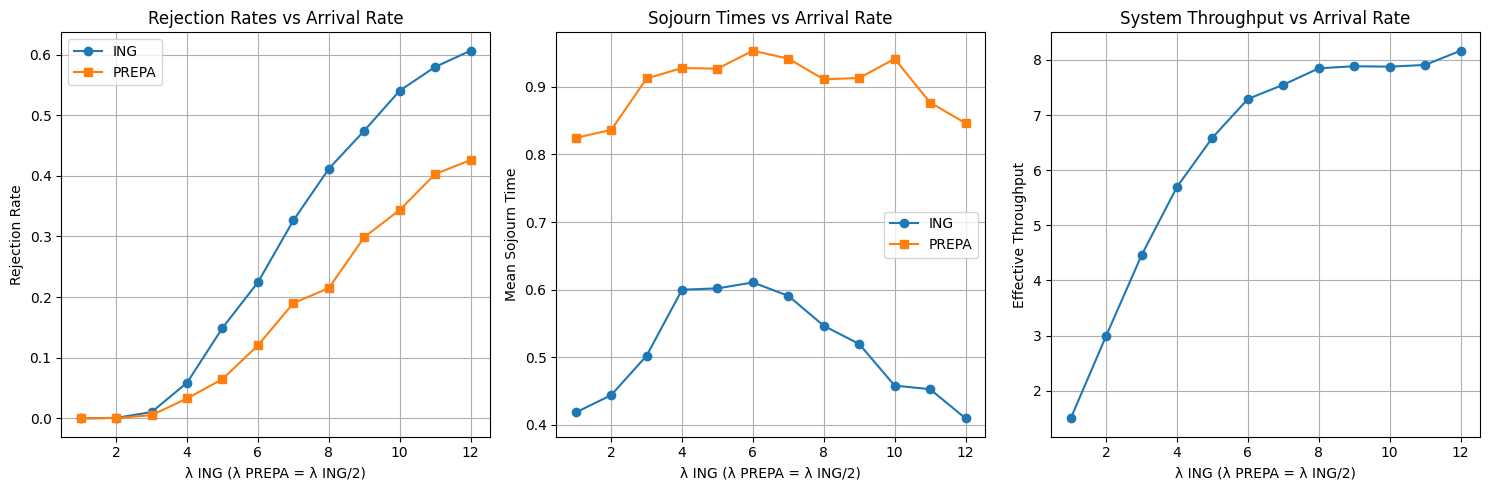


Optimal operating point (rejection rate < 10%):
λ ING: 4.00
λ PREPA: 2.00
Rejection rate ING: 5.9%
Rejection rate PREPA: 3.3%


In [53]:
def benchmark_lambda_scaling(base_mu_ing=2.4, base_mu_prepa=1.2, k=4, ks=5, test_z=5000):
    """
    Benchmark increasing lambda values while maintaining lambda_ing = 2*lambda_prepa
    """
    # Create range of lambda values to test (lambda_ing will be twice these values)
    lambda_prepa_range = np.linspace(0.5, 6.0, 12)  # Test up to lambda_ing = 12
    
    results = []
    gen = np.random.default_rng(seed=42)
    
    for lambda_prepa in lambda_prepa_range:
        lambda_ing = 2 * lambda_prepa
        
        # Run simulation
        mmk_queue = mmk_finite_two_populations(
            lamda_ing=lambda_ing,
            lamda_prepa=lambda_prepa,
            mu_ing=base_mu_ing,
            mu_prepa=base_mu_prepa,
            k=k,
            Ks=ks,
            gen=gen,
            test_z=test_z
        )
        mmk_queue.run()
        stats = mmk_queue.stats()
        
        # Calculate metrics
        ing_stats = stats[stats['Population'] == 'ING'].iloc[0]
        prepa_stats = stats[stats['Population'] == 'PREPA'].iloc[0]
        
        results.append({
            'lambda_ing': lambda_ing,
            'lambda_prepa': lambda_prepa,
            'rejection_rate_ing': ing_stats['Refused Pushes'] / (test_z/2),
            'rejection_rate_prepa': prepa_stats['Refused Pushes'] / (test_z/2),
            'sojourn_time_ing': ing_stats['Mean Sojourn Time'],
            'sojourn_time_prepa': prepa_stats['Mean Sojourn Time']
        })
    
    return pd.DataFrame(results)

# Run benchmark
results = benchmark_lambda_scaling()

# Create visualization
plt.figure(figsize=(15, 5))

# Plot 1: Rejection rates
plt.subplot(131)
plt.plot(results['lambda_ing'], results['rejection_rate_ing'], 
         marker='o', label='ING')
plt.plot(results['lambda_ing'], results['rejection_rate_prepa'], 
         marker='s', label='PREPA')
plt.xlabel('λ ING (λ PREPA = λ ING/2)')
plt.ylabel('Rejection Rate')
plt.title('Rejection Rates vs Arrival Rate')
plt.legend()
plt.grid(True)

# Plot 2: Sojourn times
plt.subplot(132)
plt.plot(results['lambda_ing'], results['sojourn_time_ing'], 
         marker='o', label='ING')
plt.plot(results['lambda_ing'], results['sojourn_time_prepa'], 
         marker='s', label='PREPA')
plt.xlabel('λ ING (λ PREPA = λ ING/2)')
plt.ylabel('Mean Sojourn Time')
plt.title('Sojourn Times vs Arrival Rate')
plt.legend()
plt.grid(True)

# Plot 3: Combined metrics
plt.subplot(133)
results['total_throughput'] = (results['lambda_ing'] * (1 - results['rejection_rate_ing']) + 
                              results['lambda_prepa'] * (1 - results['rejection_rate_prepa']))
plt.plot(results['lambda_ing'], results['total_throughput'], marker='o')
plt.xlabel('λ ING (λ PREPA = λ ING/2)')
plt.ylabel('Effective Throughput')
plt.title('System Throughput vs Arrival Rate')
plt.grid(True)

plt.tight_layout()
plt.show()

# Find optimal operating point (where rejection rate stays below 10%)
acceptable_rejection = results[
    (results['rejection_rate_ing'] < 0.1) & 
    (results['rejection_rate_prepa'] < 0.1)
].iloc[-1]

print("\nOptimal operating point (rejection rate < 10%):")
print(f"λ ING: {acceptable_rejection['lambda_ing']:.2f}")
print(f"λ PREPA: {acceptable_rejection['lambda_prepa']:.2f}")
print(f"Rejection rate ING: {acceptable_rejection['rejection_rate_ing']*100:.1f}%")
print(f"Rejection rate PREPA: {acceptable_rejection['rejection_rate_prepa']*100:.1f}%")                                                                         

# Blocage moulinettage

In [54]:
class mmk_finite_two_populations():
    """
    A class representing an M/M/K queue system with finite queue size for two populations (ING, PREPA).
    
    Attributes:
        lamda_ing (float): Arrival rate of ING population
        lamda_prepa (float): Arrival rate of PREPA population
        mu_ing (float): Service rate for ING population
        mu_prepa (float): Service rate for PREPA population
        k (int): Number of servers
        Ks (int): Maximum queue size
        gen (np.random): Random number generator
        test_z (int): Number of pushes to simulate
        refused_pushes_ing (int): Refused pushes for ING population
        refused_pushes_prepa (int): Refused pushes for PREPA population
        tops (pd.DataFrame): Timing data for each push
    """
    
    def __init__(self, lamda_ing, lamda_prepa, mu_ing, mu_prepa, k, Ks, gen, t_blocage, test_z=100):
        """
        Initialize M/M/K queue system with finite queue for two populations.
        
        Args:
            lamda_ing: Arrival rate for ING population
            lamda_prepa: Arrival rate for PREPA population
            mu_ing: Service rate for ING population
            mu_prepa: Service rate for PREPA population
            k: Number of servers
            Ks: Maximum queue size
            gen: Random number generator
            test_z: Number of pushes to simulate
        """
        # Queue parameters
        self.lamda_ing = lamda_ing
        self.lamda_prepa = lamda_prepa
        self.mu_ing = mu_ing
        self.mu_prepa = mu_prepa
        self.k = k
        self.Ks = Ks
        self.gen = gen
        self.t_size = test_z
        self.t_blocage = t_blocage
        self.refused_pushes_ing = 0
        self.refused_pushes_prepa = 0
        
        # Initialize timing DataFrame
        self.tops = pd.DataFrame(
            index=range(test_z),
            columns=['t_arrival', 't_service_start', 't_departure', 'population'],
            data=np.zeros((test_z, 4))
        )
        
    def run(self):
        """
        Simulate the M/M/K queue system with finite queue size for two populations.
        """
        print("Running the M/M/K queue simulation for two populations")
        
        # Add timing columns
        self.tops["t_waiting"] = np.zeros(self.t_size)
        self.tops["t_service"] = np.zeros(self.t_size)
        self.tops["t_sojourn"] = np.zeros(self.t_size)
        
        # Track server availability times
        server_available = np.zeros(self.k)
        
        # Generate arrival times for both populations
        arrivals_ing = np.cumsum(self.gen.exponential(1 / self.lamda_ing, self.t_size // 2))
        arrivals_prepa = np.cumsum(self.gen.exponential(1 / self.lamda_prepa, self.t_size // 2))
        
        # Merge and sort arrival times, adding population labels
        arrivals = np.concatenate((arrivals_ing, arrivals_prepa))
        populations = ['ING'] * len(arrivals_ing) + ['PREPA'] * len(arrivals_prepa)
        combined = sorted(zip(arrivals, populations))

        is_blocking = True  # Start with blocking
        block_start_time = 0
        block_period = self.t_blocage  # Total block duration
        unblock_period = self.t_blocage / 2
        
        # Process pushes
        for i, (arrival_time, population) in enumerate(combined):
            current_time = arrival_time

            time_since_block_start = current_time - block_start_time
            if is_blocking and time_since_block_start >= block_period:
                is_blocking = False
                block_start_time = current_time
            elif not is_blocking and time_since_block_start >= unblock_period:
                is_blocking = True
                block_start_time = current_time

            if is_blocking and population == 'ING':
                self.refused_pushes_ing += 1
                continue 

            self.tops.loc[i, "t_arrival"] = arrival_time
            self.tops.loc[i, "population"] = population
            
            # Count pushes currently in queue
            current_time = arrival_time
            in_queue = ((self.tops["t_arrival"] <= current_time) & 
                       (self.tops["t_service_start"] > current_time)).sum()
            
            # Check if queue size limit is exceeded
            if in_queue >= self.Ks:
                if population == 'ING':
                    self.refused_pushes_ing += 1
                else:
                    self.refused_pushes_prepa += 1
                continue
                
            # Find first available server
            server_idx = np.argmin(server_available)
            
            # Calculate service start time
            self.tops.loc[i, "t_service_start"] = max(server_available[server_idx], arrival_time)
            
            # Calculate waiting and service times
            self.tops.loc[i, "t_waiting"] = self.tops.loc[i, "t_service_start"] - arrival_time
            if population == 'ING':
                self.tops.loc[i, "t_service"] = self.gen.exponential(1 / self.mu_ing)
            else:
                self.tops.loc[i, "t_service"] = self.gen.exponential(1 / self.mu_prepa)
            
            # Calculate departure time
            self.tops.loc[i, "t_departure"] = self.tops.loc[i, "t_service_start"] + self.tops.loc[i, "t_service"]
            self.tops.loc[i, "t_sojourn"] = self.tops.loc[i, "t_waiting"] + self.tops.loc[i, "t_service"]
            
            # Update server availability
            server_available[server_idx] = self.tops.loc[i, "t_departure"]

    def counts(self, t_intervals, population= "BOTH"):
        """
        Compute number of pushes in system at regular time intervals.
        
        Args:
            t_intervals: Time interval size for measurements
            
        Returns:
            DataFrame with counts of pushes in system, queue and service
        """
        t_max = self.tops["t_departure"].max()
        t_points = np.arange(0, t_max, t_intervals)
        
        counts = pd.DataFrame(
            index=t_points,
            columns=['ag_in_sys', 'ag_in_queue', 'ag_in_service'],
            data=np.zeros((len(t_points), 3))
        )

        if (population == "BOTH"):
            for t in t_points:
                in_sys = ((self.tops["t_arrival"] <= t) & (self.tops["t_departure"] > t)).sum()
                in_queue = ((self.tops["t_arrival"] <= t) & (self.tops["t_service_start"] > t)).sum()
                in_service = ((self.tops["t_service_start"] <= t) & (self.tops["t_departure"] > t)).sum()
                
                counts.loc[t] = [in_sys, in_queue, in_service]
        
        else:
            filtered_tops = self.tops[self.tops["population"] == population]

            for t in t_points:
                in_sys = ((filtered_tops["t_arrival"] <= t) & (filtered_tops["t_departure"] > t)).sum()
                in_queue = ((filtered_tops["t_arrival"] <= t) & (filtered_tops["t_service_start"] > t)).sum()
                in_service = ((filtered_tops["t_service_start"] <= t) & (filtered_tops["t_departure"] > t)).sum()
                
                counts.loc[t] = [in_sys, in_queue, in_service]     
        return counts
    
    def stats(self):
        """
        Compute summary statistics for the two populations.
        
        Returns:
            DataFrames with statistics for each population.
        """
        stats_ing = self.tops[self.tops["population"] == 'ING'][["t_waiting", "t_service", "t_sojourn"]].mean()
        stats_prepa = self.tops[self.tops["population"] == 'PREPA'][["t_waiting", "t_service", "t_sojourn"]].mean()
        
        stats = pd.DataFrame({
            'Population': ['ING', 'PREPA'],
            'Mean Waiting Time': [stats_ing["t_waiting"], stats_prepa["t_waiting"]],
            'Mean Service Time': [stats_ing["t_service"], stats_prepa["t_service"]],
            'Mean Sojourn Time': [stats_ing["t_sojourn"], stats_prepa["t_sojourn"]],
            'Refused Pushes': [self.refused_pushes_ing, self.refused_pushes_prepa]
        })
        
        return stats

Running the M/M/K queue simulation for two populations


/tmp/ipykernel_4744/3794643555.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'PREPA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.tops.loc[i, "population"] = population


Running the M/M/1 queue simulation with finite capacity

Statistiques de la file M/M/K:
  Population  Mean Waiting Time  Mean Service Time  Mean Sojourn Time  \
0        ING           0.017838           0.412458           0.430296   
1      PREPA           0.008968           0.828688           0.837656   

   Refused Pushes  
0            1642  
1               0  

Statistiques de la file M/M/1:
(                         value
mean_sojourn_time     1.878618
mean_waiting_time     1.459969
mean_service_time     0.418648
refused_pushes     2545.000000,       Arrival Time  Departure Time
0         0.529900        1.962685
1         0.000000        2.895539
2         2.292533        2.909232
3         0.000000        3.144414
4         0.000000        3.507757
...            ...             ...
4995   2386.102057        0.000000
4996   2385.430982        0.000000
4997   2386.022210        0.000000
4998   2386.504740        0.000000
4999   2388.099902     2391.543139

[5000 rows x 2 columns

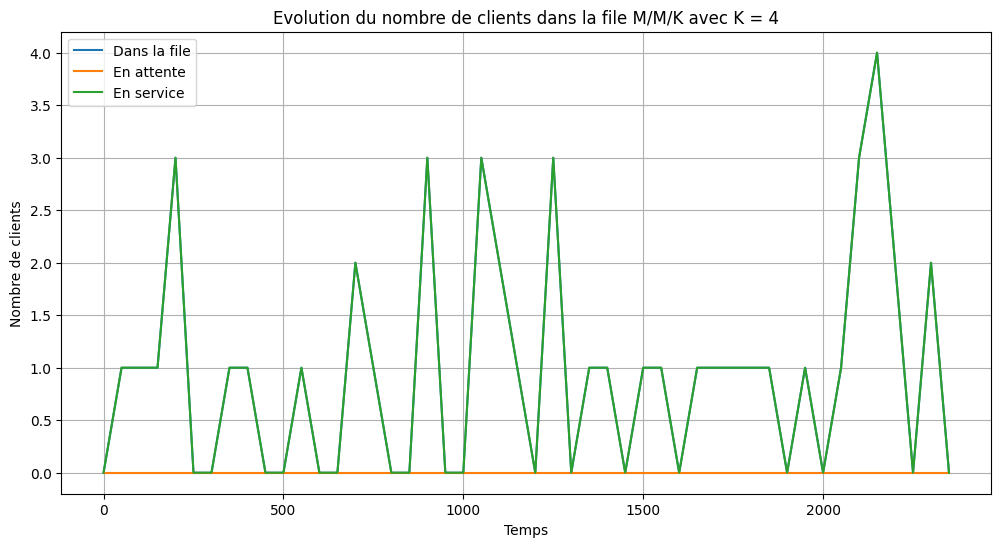

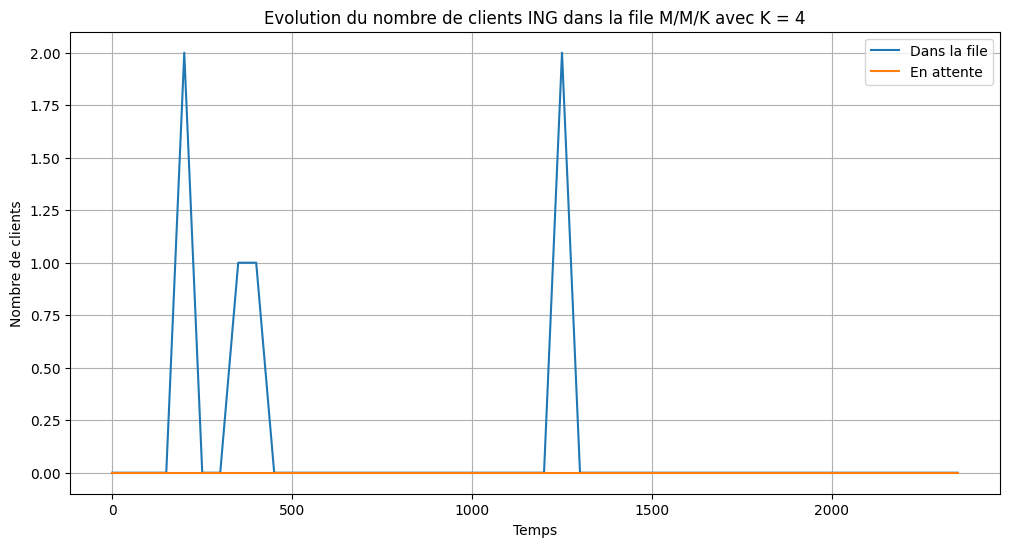

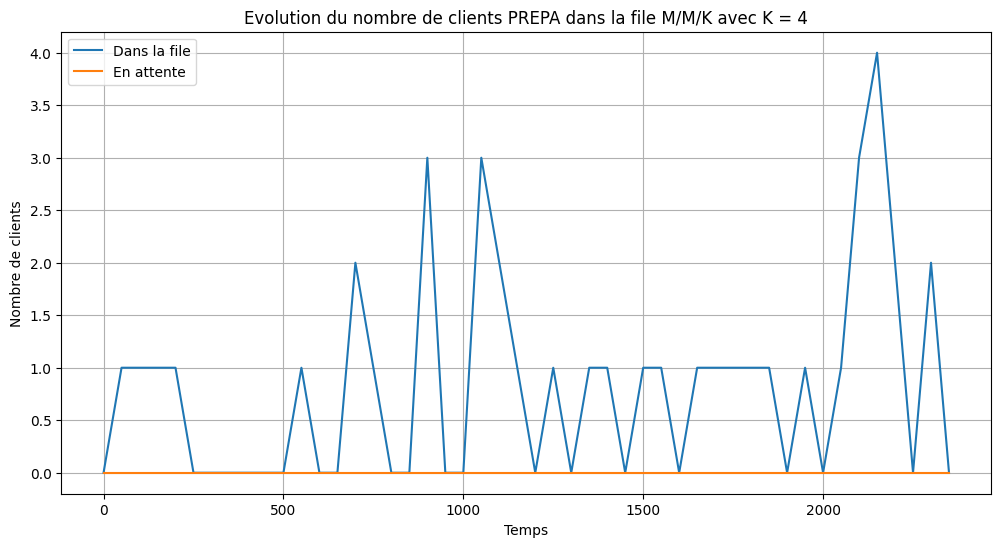

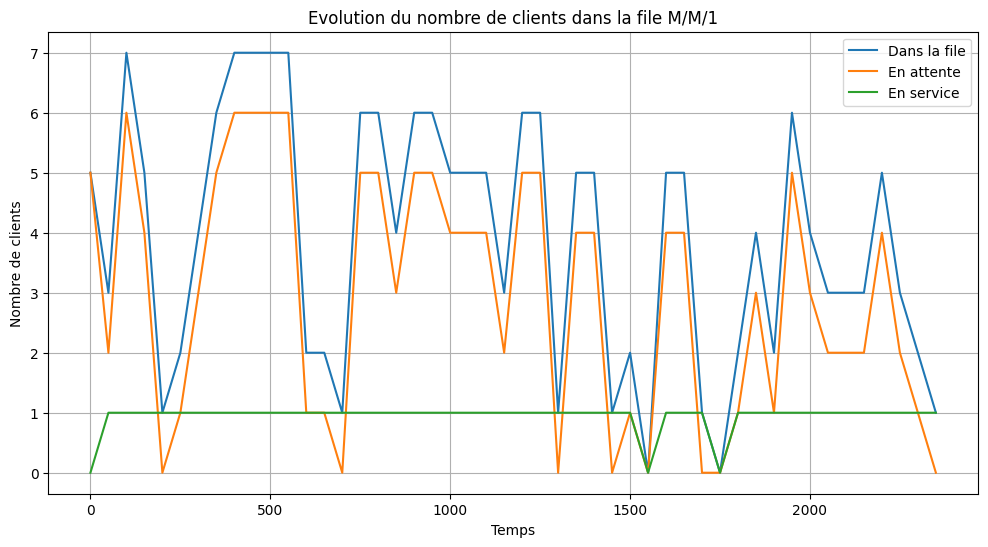

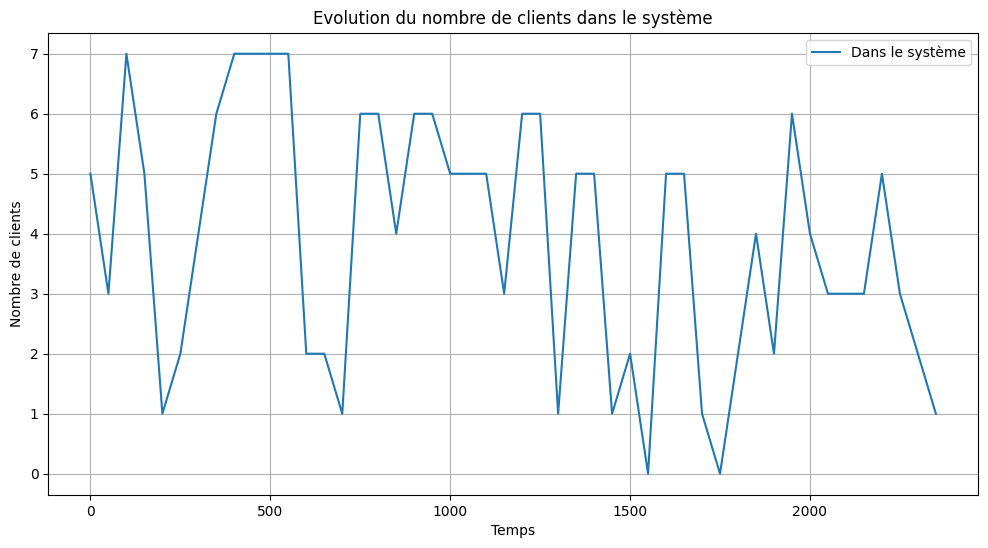

In [55]:
# Paramètres de la file M/M/K
lambda_arr_ing = 2.0  # Taux d'arrivée des pushs
lambda_arr_prepa = 1.0
mu_1_ing = 2.4 
mu_1_prepa = 1.2       # Taux de service des serveurs
K = 4            # Nombre de serveurs
gen = np.random.default_rng(seed=42)
z = 5000
Ks = 5
Kf = 5
t_blocage = 200

# Paramètres de la file M/M/1
lambda_arr_2 = 1.0  # Taux d'arrivée des pushs
mu_2 = 1.2       # Taux de service du serveur

# Créer une instance de la file M/M/K
mmk_queue = mmk_finite_two_populations(lamda_ing=lambda_arr_ing, lamda_prepa=lambda_arr_prepa,mu_ing=mu_1_ing, mu_prepa=mu_1_prepa, k=K, Ks=Ks, gen=gen, t_blocage=5 ,test_z=z)

# Simuler la file d'attente
mmk_queue.run()

prev_tops = pd.DataFrame(
                index=range(z),
                columns=['t_arrival', 't_service_start', 't_departure'],
                data=np.zeros((z, 3))
            )
prev_tops["t_arrival"] = mmk_queue.tops["t_departure"]

# Créer une instance de la file M/M/1
mm1_queue = mm1_finite(lamda=lambda_arr_2, mu=mu_2, gen=gen, Kf=Kf, test_z=z, previous_tops=prev_tops)

# Simuler la file d'attente
mm1_queue.run()

# Afficher les statistiques
print("\nStatistiques de la file M/M/K:")
print(mmk_queue.stats())

print("\nStatistiques de la file M/M/1:")
print(mm1_queue.stats())

# Calculer les comptages à intervalles réguliers pour la file M/M/K
counts_df_k = mmk_queue.counts(t_intervals=50,)

# Tracer l'évolution du nombre de clients dans la file M/M/K
plt.figure(figsize=(12, 6))
plt.plot(counts_df_k.index, counts_df_k['ag_in_sys'], label='Dans la file')
plt.plot(counts_df_k.index, counts_df_k['ag_in_queue'], label='En attente')
plt.plot(counts_df_k.index, counts_df_k['ag_in_service'], label='En service')
plt.xlabel('Temps')
plt.ylabel('Nombre de clients')
plt.title('Evolution du nombre de clients dans la file M/M/K avec K = ' + str(K))
plt.legend()
plt.grid(True)
plt.show()

# Tracer l'évolution du nombre de clients ing dans la file M/M/K
counts_df_k = mmk_queue.counts(t_intervals=50, population="ING")

plt.figure(figsize=(12, 6))
plt.plot(counts_df_k.index, counts_df_k['ag_in_sys'], label='Dans la file')
plt.plot(counts_df_k.index, counts_df_k['ag_in_queue'], label='En attente')
#plt.plot(counts_df_k.index, counts_df_k['ag_in_service'], label='En service')
plt.xlabel('Temps')
plt.ylabel('Nombre de clients')
plt.title('Evolution du nombre de clients ING dans la file M/M/K avec K = ' + str(K))
plt.legend()
plt.grid(True)
plt.show()

# Tracer l'évolution du nombre de clients prepa dans la file M/M/K
counts_df_k = mmk_queue.counts(t_intervals=50, population="PREPA")

plt.figure(figsize=(12, 6))
plt.plot(counts_df_k.index, counts_df_k['ag_in_sys'], label='Dans la file')
plt.plot(counts_df_k.index, counts_df_k['ag_in_queue'], label='En attente')
#plt.plot(counts_df_k.index, counts_df_k['ag_in_service'], label='En service')
plt.xlabel('Temps')
plt.ylabel('Nombre de clients')
plt.title('Evolution du nombre de clients PREPA dans la file M/M/K avec K = ' + str(K))
plt.legend()
plt.grid(True)
plt.show()

# Calculer les comptages à intervalles réguliers pour la file M/M/1
counts_df_1 = mm1_queue.counts(t_intervals=50)

# Tracer l'évolution du nombre de clients dans la file M/M/1
plt.figure(figsize=(12, 6))
plt.plot(counts_df_1.index, counts_df_1['ag_in_sys'], label='Dans la file')
plt.plot(counts_df_1.index, counts_df_1['ag_in_queue'], label='En attente')
plt.plot(counts_df_1.index, counts_df_1['ag_in_service'], label='En service')
plt.xlabel('Temps')
plt.ylabel('Nombre de clients')
plt.title('Evolution du nombre de clients dans la file M/M/1')
plt.legend()
plt.grid(True)
plt.show()

# Tracer l'évolution du nombre de clients dans le système
plt.figure(figsize=(12, 6))
plt.plot(counts_df_1.index, counts_df_1['ag_in_sys'], label='Dans le système')
plt.xlabel('Temps')
plt.ylabel('Nombre de clients')
plt.title('Evolution du nombre de clients dans le système')
plt.legend()
plt.grid(True)
plt.show()